In [1]:
import networkx as nx
import numpy as np
import tweepy, gensim, nltk, yaml, os, sys
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
from scipy.spatial import distance

sys.path.append(os.path.abspath("../../src/"))
from helper.utils import *
from helper.convmanager import *

twaccess = TwitterAccess('../../res/credentials.yml')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/piemontec/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Get tweets

In [2]:
%%time
# stackoverflow
search_options = {
    'q':          'trump',      # query from trending topic
    'lang':       'en',                    # language
    'tweet_mode': 'extended'               # get full tweet text
}
statuses = tweepy.Cursor(twaccess.api.search, **search_options).items(1000)
tweets   = [[convert(status)] for status in statuses if is_response(status)]
convs    = [extend(twaccess.api, tweet) for tweet in tweets]
merged_convs = merge_conversations(convs)

print('Response tweets:', len(tweets))
print('Max conversation length:', max([len(c) for c in convs]), '\n')
print('Max users in a conversation:', max([get_num_users(c) for c in convs]), '\n')

Response tweets: 121
Max conversation length: 341 

Max users in a conversation: 36 

CPU times: user 16.6 s, sys: 1.37 s, total: 18 s
Wall time: 5min 29s


In [3]:
# a = [(i, len(c), get_num_users(c)) for i, c in enumerate(merged_convs) if len(c) > 5]
# a

### Build the Graph

In [4]:
%%time
plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

ConvGraph = nx.DiGraph()
# model = gensim.models.KeyedVectors.load_word2vec_format('../../models/pretrained/GoogleNews-vectors-negative300.bin.gz', binary=True)

# best_conv = [max(merged_convs, key=len)] 
best_conv = [max(merged_convs, key=get_num_users)]

for conv in best_conv:
    for i, tweet in enumerate(conv):
        if tweet.reply_to is not None:
            answered_tweet = conv[i+1]
            similarity = tweet.get_similarity(answered_tweet)
            ConvGraph.add_edge(tweet.user, answered_tweet.user, weight=similarity)   # or if the edge already exist change the weight
        else:
            pass
            # ConvGraph.add_edge(tweet.user, tweet.reply_to, weight=similarity)

CPU times: user 12.2 ms, sys: 2.11 ms, total: 14.3 ms
Wall time: 13 ms


#### Draw the Graph

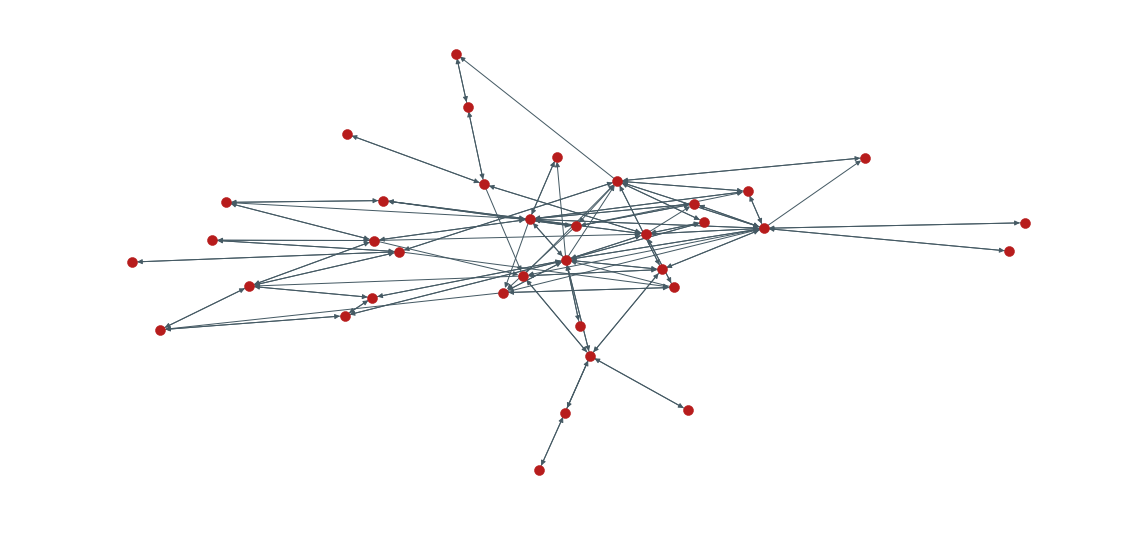

In [7]:
pos = nx.spring_layout(ConvGraph)
edge_labels = nx.get_edge_attributes(ConvGraph, 'weight')

draw_options = {
    'with_labels': False,
    'node_shape' : 'o',
    'node_color' : '#B71C1C',
    'edge_color' : '#455A64',
    'node_size'  : 100,
    'width': 1
}

nx.draw(ConvGraph, pos, **draw_options)
# nx.draw_networkx_edge_labels(ConvGraph, pos, edge_labels=edge_labels, font_color='#006064');